In [1]:
%load_ext autoreload
%autoreload 2
import sys
#sys.path.insert(1, '/home/jw3514/Work/CellType_Psy/src')
sys.path.insert(1, '/home/jw3514/Work/UNIMED/src')
from CellType_PSY import *
from UNIMED import *
import yaml
#import scanpy as sc
HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol = LoadGeneINFO()

os.chdir("/home/jw3514/Work/UNIMED/notebooks/")

with open("../config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [2]:
bias_path = config["bias_matrices"]["HumanCT"]
BiasMat = pd.read_parquet(bias_path)
BiasMat.head()

,0,1,2,3,4,5,6,7,8,9,...,451,452,453,454,455,456,457,458,459,460
79933,0.000000,0.247722,0.000000,0.000000,0.626093,0.629072,0.835162,0.871491,0.733452,0.724300,...,0.218467,0.153210,0.361680,0.224626,0.186763,0.380631,0.206127,0.208194,0.835834,1.361641
94015,0.967876,1.003459,0.817904,1.221713,1.335388,1.236983,1.285263,1.298542,1.316471,1.291370,...,0.082907,0.054944,0.053659,0.068484,0.174067,0.089874,0.156684,0.041619,0.034585,0.097497
55238,0.000000,0.445792,0.643713,0.857660,0.740146,0.847446,1.041819,0.841990,0.893640,0.925301,...,1.670772,1.168358,1.188660,1.581394,1.504396,1.427165,1.897258,1.535990,1.070745,1.172842
23429,1.230105,0.995262,1.075766,1.221713,1.179390,0.871827,0.972449,0.969319,0.963415,0.914487,...,0.736361,0.475144,0.748478,0.611151,0.665781,0.734392,0.666132,0.661863,0.907057,0.708619
6534,0.000000,0.188154,0.481055,0.457698,0.374333,0.295595,0.326481,0.294421,0.389148,0.425369,...,1.807810,1.532331,1.803053,1.756628,1.865358,1.145665,1.897258,1.875907,1.917926,0.840748


### Magma Based Gene Level Correlation and PCA

In [3]:
PGC_Trait_Names = ["ASD", "SCZ", "BP", "ADHD", "MDD", "OCD", "TS", "PD", "AN", "EDU", "PTSD"]
DIR = "/home/jw3514/Work/UNIMED/dat/Genetics/GWAS/MagmaGeneRes/"
Psy_GWAS_DF = {}
for Name in PGC_Trait_Names:
    Psy_GWAS_DF[Name] = pd.read_csv(f"{DIR}/{Name}.magma.genes.out.tsv", sep="\t", index_col="GENE")
    Psy_GWAS_DF[Name] = Psy_GWAS_DF[Name].sort_values("ZSTAT", ascending=False)

All_ZSTAT_DF = pd.DataFrame()
for disorder in PGC_Trait_Names:
    All_ZSTAT_DF[disorder] = Psy_GWAS_DF[disorder]["ZSTAT"]
All_ZSTAT_DF = All_ZSTAT_DF.fillna(0)

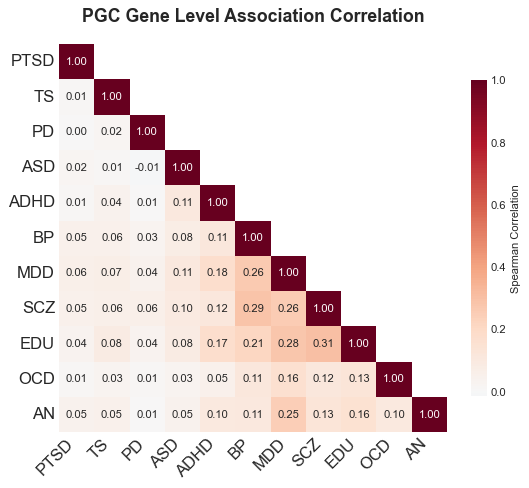

In [4]:
PGC_Magma_Correlation = plot_disorder_correlation_heatmap(All_ZSTAT_DF, "PGC Gene Level Association Correlation")

In [5]:
PGC_Magma_Correlation.to_csv("/home/jw3514/Work/UNIMED/results/pfactor/PGC_Magma_Correlation.csv")

#### Gene level PCA

In [6]:
GeneZstat_scaled, GeneZstat_pca, GeneZstat_pca_result, GeneZstat_loadings = perform_pca_analysis(All_ZSTAT_DF)
GeneZstat_pc_scores_df = pd.DataFrame(
    GeneZstat_pca_result,
    index=All_ZSTAT_DF.index, 
    columns=[f'PC{i+1}' for i in range(GeneZstat_pca_result.shape[1])]
)

Explained variance ratios:
PC1: 0.224 (22.4%)
PC2: 0.094 (9.4%)
PC3: 0.092 (9.2%)
PC4: 0.089 (8.9%)
PC5: 0.088 (8.8%)
PC6: 0.083 (8.3%)
PC7: 0.080 (8.0%)
PC8: 0.076 (7.6%)
PC9: 0.066 (6.6%)
PC10: 0.056 (5.6%)
PC11: 0.052 (5.2%)

Cumulative variance explained: 100.0%

PC1 loadings:
MDD     0.452312
SCZ     0.428274
EDU     0.402129
BP      0.377362
AN      0.321688
ADHD    0.273869
OCD     0.258118
ASD     0.178020
TS      0.122914
PTSD    0.110149
PD      0.061986
Name: PC1, dtype: float64


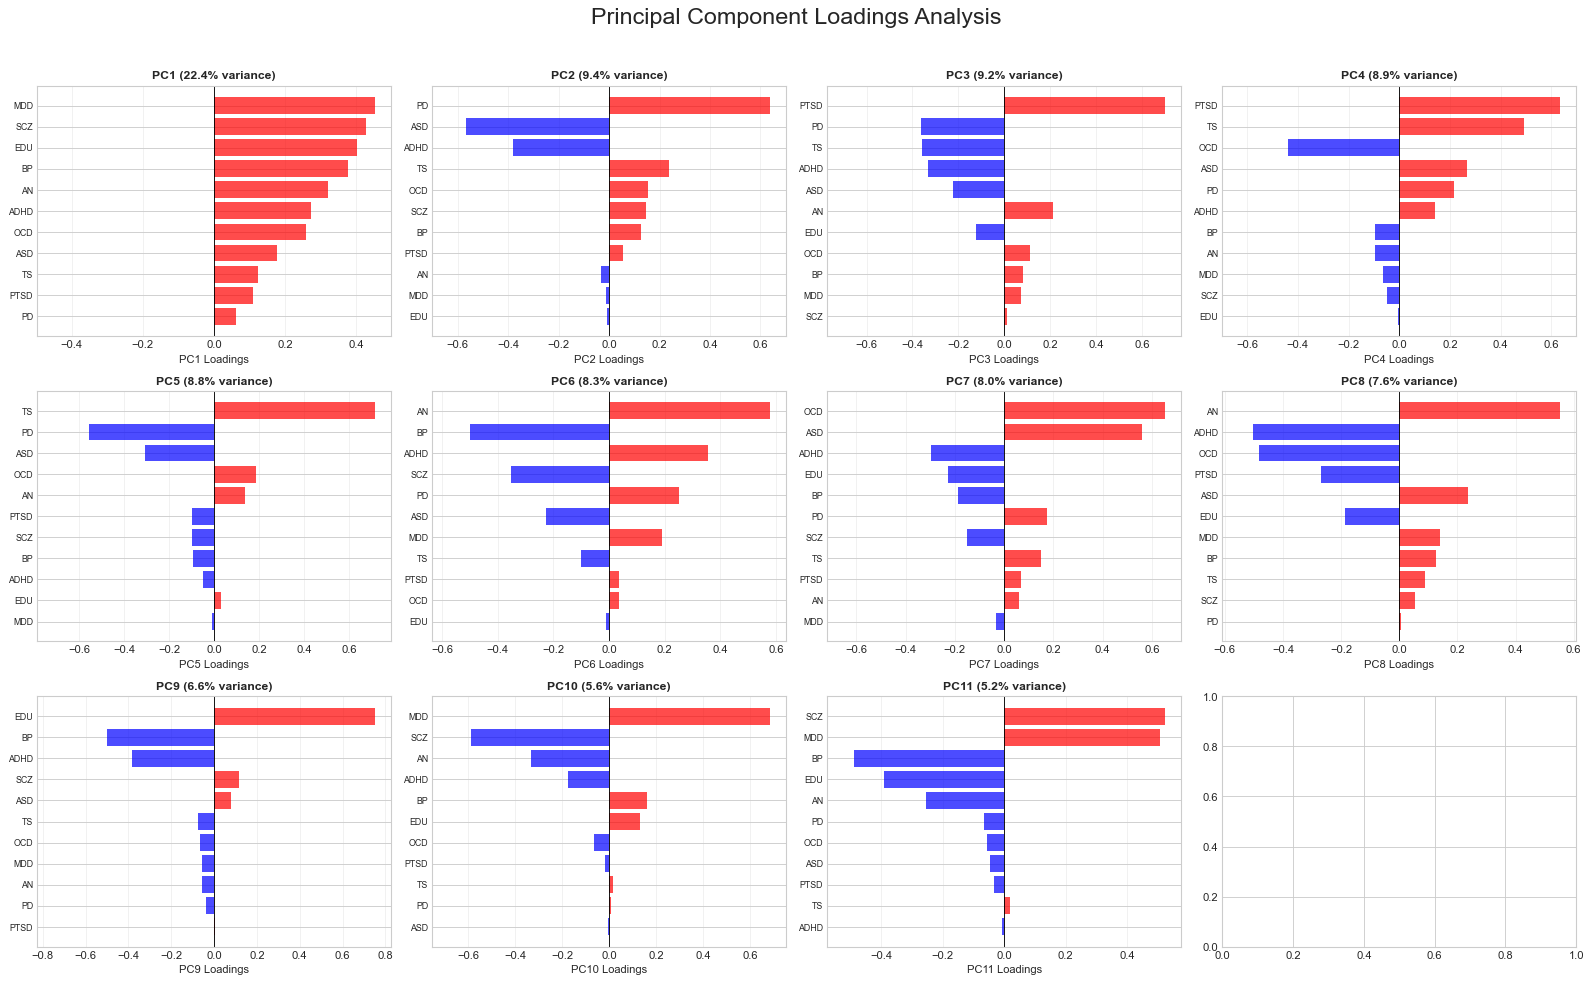

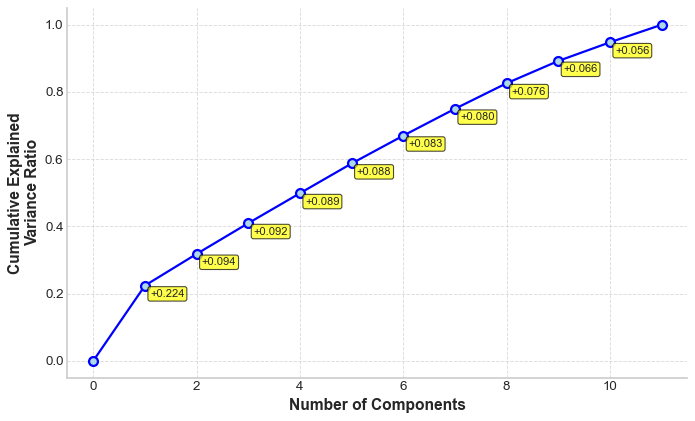

In [7]:
plot_pc_loadings(GeneZstat_pca, All_ZSTAT_DF)
plot_scree_and_get_loadings(GeneZstat_pca)

In [8]:
explained_variance_df = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(GeneZstat_pca.explained_variance_ratio_))],
    'explained_variance_ratio': GeneZstat_pca.explained_variance_ratio_,
    'cumulative_variance_ratio': np.cumsum(GeneZstat_pca.explained_variance_ratio_)
})
output_dir = "/home/jw3514/Work/UNIMED/results/pca/PGC/"
explained_variance_file = os.path.join(output_dir, "MagmaGene_explained_variance_ratio.csv")
explained_variance_df.to_csv(explained_variance_file, index=False)
print(f"Saved explained variance ratios to {explained_variance_file}")

Saved explained variance ratios to /home/jw3514/Work/UNIMED/results/pca/PGC/MagmaGene_explained_variance_ratio.csv


### Human CT PCA (all gene include)

In [9]:
# Read Magma GWAS Results
gwas = "PGC"
Exclude = "Empty"
Mode = "HumanCT"
Bias = "top_gene_enrich"

DIR = f"/home/jw3514/Work/UNIMED/results/assoc/{gwas}/{Mode}/{Bias}.{Exclude}"
Psy_GWAS_CTBias_DF = {}
for Name in PGC_Trait_Names:
    Psy_GWAS_CTBias_DF[Name] = pd.read_csv("{}/HumanCT.{}.csv".format(DIR,Name), sep=",", index_col=0)

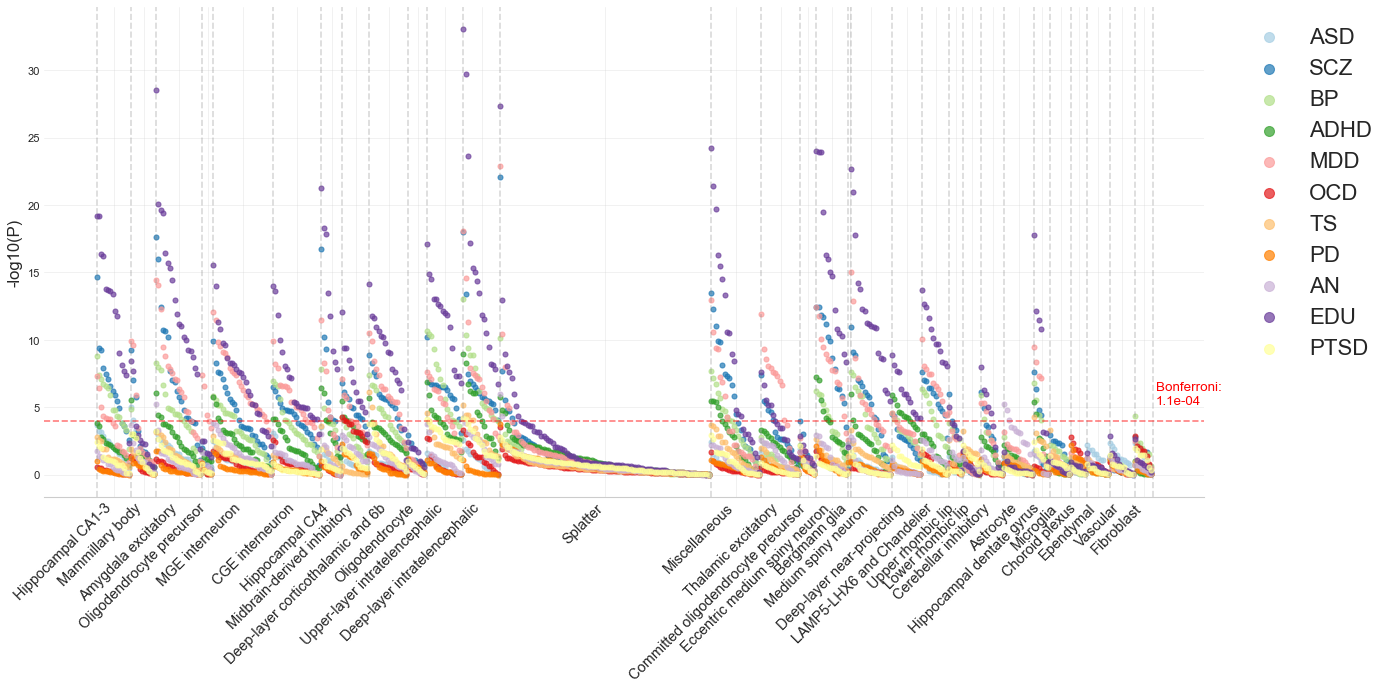

In [10]:
def plot_supercluster_specificity(
    Psy_GWAS_CTBias_DF, 
    Disorders, 
    colors, 
    n_tests=461, 
    figsize=(20, 9), 
    dpi=80
):

    # Create figure with extra bottom margin for rotated labels and transparent background
    plt.figure(figsize=figsize, dpi=dpi, facecolor='none', edgecolor='none')
    ax = plt.gca()
    ax.set_facecolor('none')

    # Process first disorder to establish common supercluster ordering
    df_first = Psy_GWAS_CTBias_DF[Disorders[0]].copy()
    supercluster_means = df_first.groupby('Supercluster')['beta'].mean().sort_values(ascending=False)
    sorted_superclusters = supercluster_means.index.tolist()

    # Will be overwritten in each loop, but we want the last one for boundaries
    supercluster_boundaries = []

    # Process each disorder using the same supercluster ordering
    for disorder, color in zip(Disorders, colors):
        df = Psy_GWAS_CTBias_DF[disorder].copy()
        
        # Convert values to -log10(1-p)
        df['value'] = -np.log10(df['pvalue'])
        
        # Sort data using common supercluster ordering
        df['supercluster_order'] = df['Supercluster'].map({sc: i for i, sc in enumerate(sorted_superclusters)})
        df = df.sort_values(['supercluster_order', 'value'], ascending=[True, False])
        
        # Get supercluster grouping info
        supercluster_groups = {sc: df[df['Supercluster'] == sc].index for sc in sorted_superclusters}
        
        # Calculate supercluster boundaries
        supercluster_boundaries = []
        current_pos = 0
        for sc in sorted_superclusters:
            indices = [df.index.get_loc(idx) for idx in supercluster_groups[sc]]
            supercluster_boundaries.append(current_pos)
            current_pos += len(indices)
        supercluster_boundaries.append(current_pos)
        
        # Plot points for this disorder
        plt.scatter(range(len(df)), df['value'], alpha=0.7, color=color, label=disorder, s=20)

    # Add vertical lines at supercluster boundaries
    for boundary in supercluster_boundaries:
        plt.axvline(x=boundary, color='gray', linestyle='--', alpha=0.3)

    # Add horizontal line at Bonferroni threshold
    bonferroni_threshold = -np.log10(0.05/n_tests)
    plt.axhline(y=bonferroni_threshold, color='red', linestyle='--', alpha=0.5)
    # annotate its pvalue
    plt.text(n_tests+1, bonferroni_threshold + 2, f'Bonferroni: \n{0.05/n_tests:.1e}', ha='left', va='center', fontsize=12, color='red')

    # Calculate center position for each supercluster
    supercluster_centers = {}
    for i, sc in enumerate(sorted_superclusters):
        supercluster_centers[sc] = (supercluster_boundaries[i] + supercluster_boundaries[i+1]) / 2

    # Add supercluster labels at center positions
    plt.xticks([supercluster_centers[sc] for sc in sorted_superclusters], 
               sorted_superclusters,
               rotation=45,
               fontsize=13,
               ha='right')

    # Customize plot
    #plt.xlabel('Cell Type Superclusters')
    plt.ylabel('-log10(P)', fontsize=15)
    #plt.title('Cell Type Specificity Across Psychiatric Disorders')
    plt.grid(True, alpha=0.3)

    # Move legend outside of plot
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=20, markerscale=2)
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Adjust layout to prevent label cutoff and accommodate legend
    plt.subplots_adjust(bottom=0.2, right=0.85)
    plt.show()

# Example usage:
# plot_supercluster_specificity(Psy_GWAS_CTBias_DF, PGC_Trait_Names, colors)

colors = [
    "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99",
    "#e31a1c", "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a", "#ffff99"
]

plot_supercluster_specificity(Psy_GWAS_CTBias_DF, PGC_Trait_Names, colors)

In [11]:
PsyDisorders_2 = ["ASD", "SCZ", "BP", "ADHD", "MDD", "OCD","TS", "AN", "PTSD", "PD", "EDU"]
#h2_LDSC = [0.118, 0.244, 0.196, 0.199, 0.103, 0.367, 0.252, 0.044, 0.09, ]
h2_LDSC = [0.118, 0.244, 0.196, 0.199, 0.103, 0.28, 0.252, 0.044, 0.09, 0.148, 0.03]
h2_se_LDSC = [0.012, 0.0095, 0.0111, 0.0128, 0.0072, 0.0589, 0.0332, 0.0034, 0.0083, 0.002, 0.003]
SampleSize = [18381, 76755, 41917, 38691 , 88316, 2688, 4819, 74973, 11920, 10000, 2248]
neff_values = [
    21945,   # ASD
    55115,   # SCZ
    71385,   # BP
    26126,   # ADHD
    1014821,   # MDD
    38193,    # OCD
    6371,    # TS
    36647,   # Anxiety
    17531,   # PTSD
    3265,    # PD (Panic Disorder)
    405072   # EDU
]

In [12]:
N_sigCT_list = []
N_sig_count_list = []
for disorder in PsyDisorders_2:
    # Get number of significant cell types (p < 0.05/200)
    N_sig_count = len(Psy_GWAS_CTBias_DF[disorder][Psy_GWAS_CTBias_DF[disorder]["pvalue"] < 0.05/200])
    N_sig_count_list.append(N_sig_count)
    
    # Get mean effect size of top 50 cell types
    N_sigCT = Psy_GWAS_CTBias_DF[disorder].head(50)["beta"].mean()
    N_sigCT_list.append(N_sigCT)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


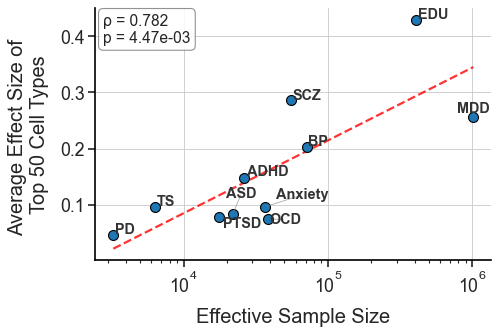

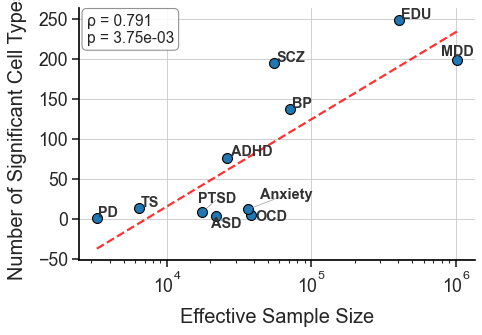

In [13]:

create_scatter_plot(
    x_values=neff_values,
    y_values=N_sigCT_list,
    xlabel="Effective Sample Size",
    ylabel="Average Effect Size of \nTop 50 Cell Types", 
    disorders=['ASD', 'SCZ', 'BP', 'ADHD', 'MDD', 'OCD', 'TS', 'Anxiety', 'PTSD', 'PD', 'EDU']
)

# Plot number of significant cell types vs sample size  
create_scatter_plot(
    x_values=neff_values,
    y_values=N_sig_count_list,
    xlabel="Effective Sample Size",
    ylabel="Number of Significant Cell Types",
    disorders=['ASD', 'SCZ', 'BP', 'ADHD', 'MDD', 'OCD', 'TS', 'Anxiety', 'PTSD', 'PD', 'EDU']
)

### Correlation and PCA

In [14]:
All_Bias_DF_Spec = pd.read_csv("/home/jw3514/Work/UNIMED/results/pca/PGC/HumanCT/top_gene_enrich.Empty/combined_bias_data.csv", index_col=0)

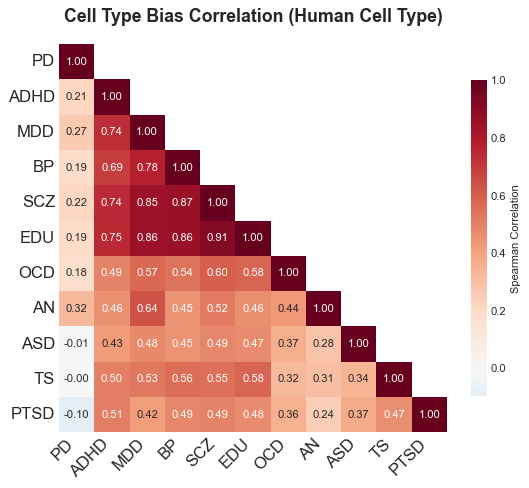

In [15]:
HumanCT_Bias_Correlation = plot_disorder_correlation_heatmap(All_Bias_DF_Spec, "Cell Type Bias Correlation (Human Cell Type)")
HumanCT_Bias_Correlation.to_csv("/home/jw3514/Work/UNIMED/results/pfactor/PGC_HumanCT_Correlation.csv")

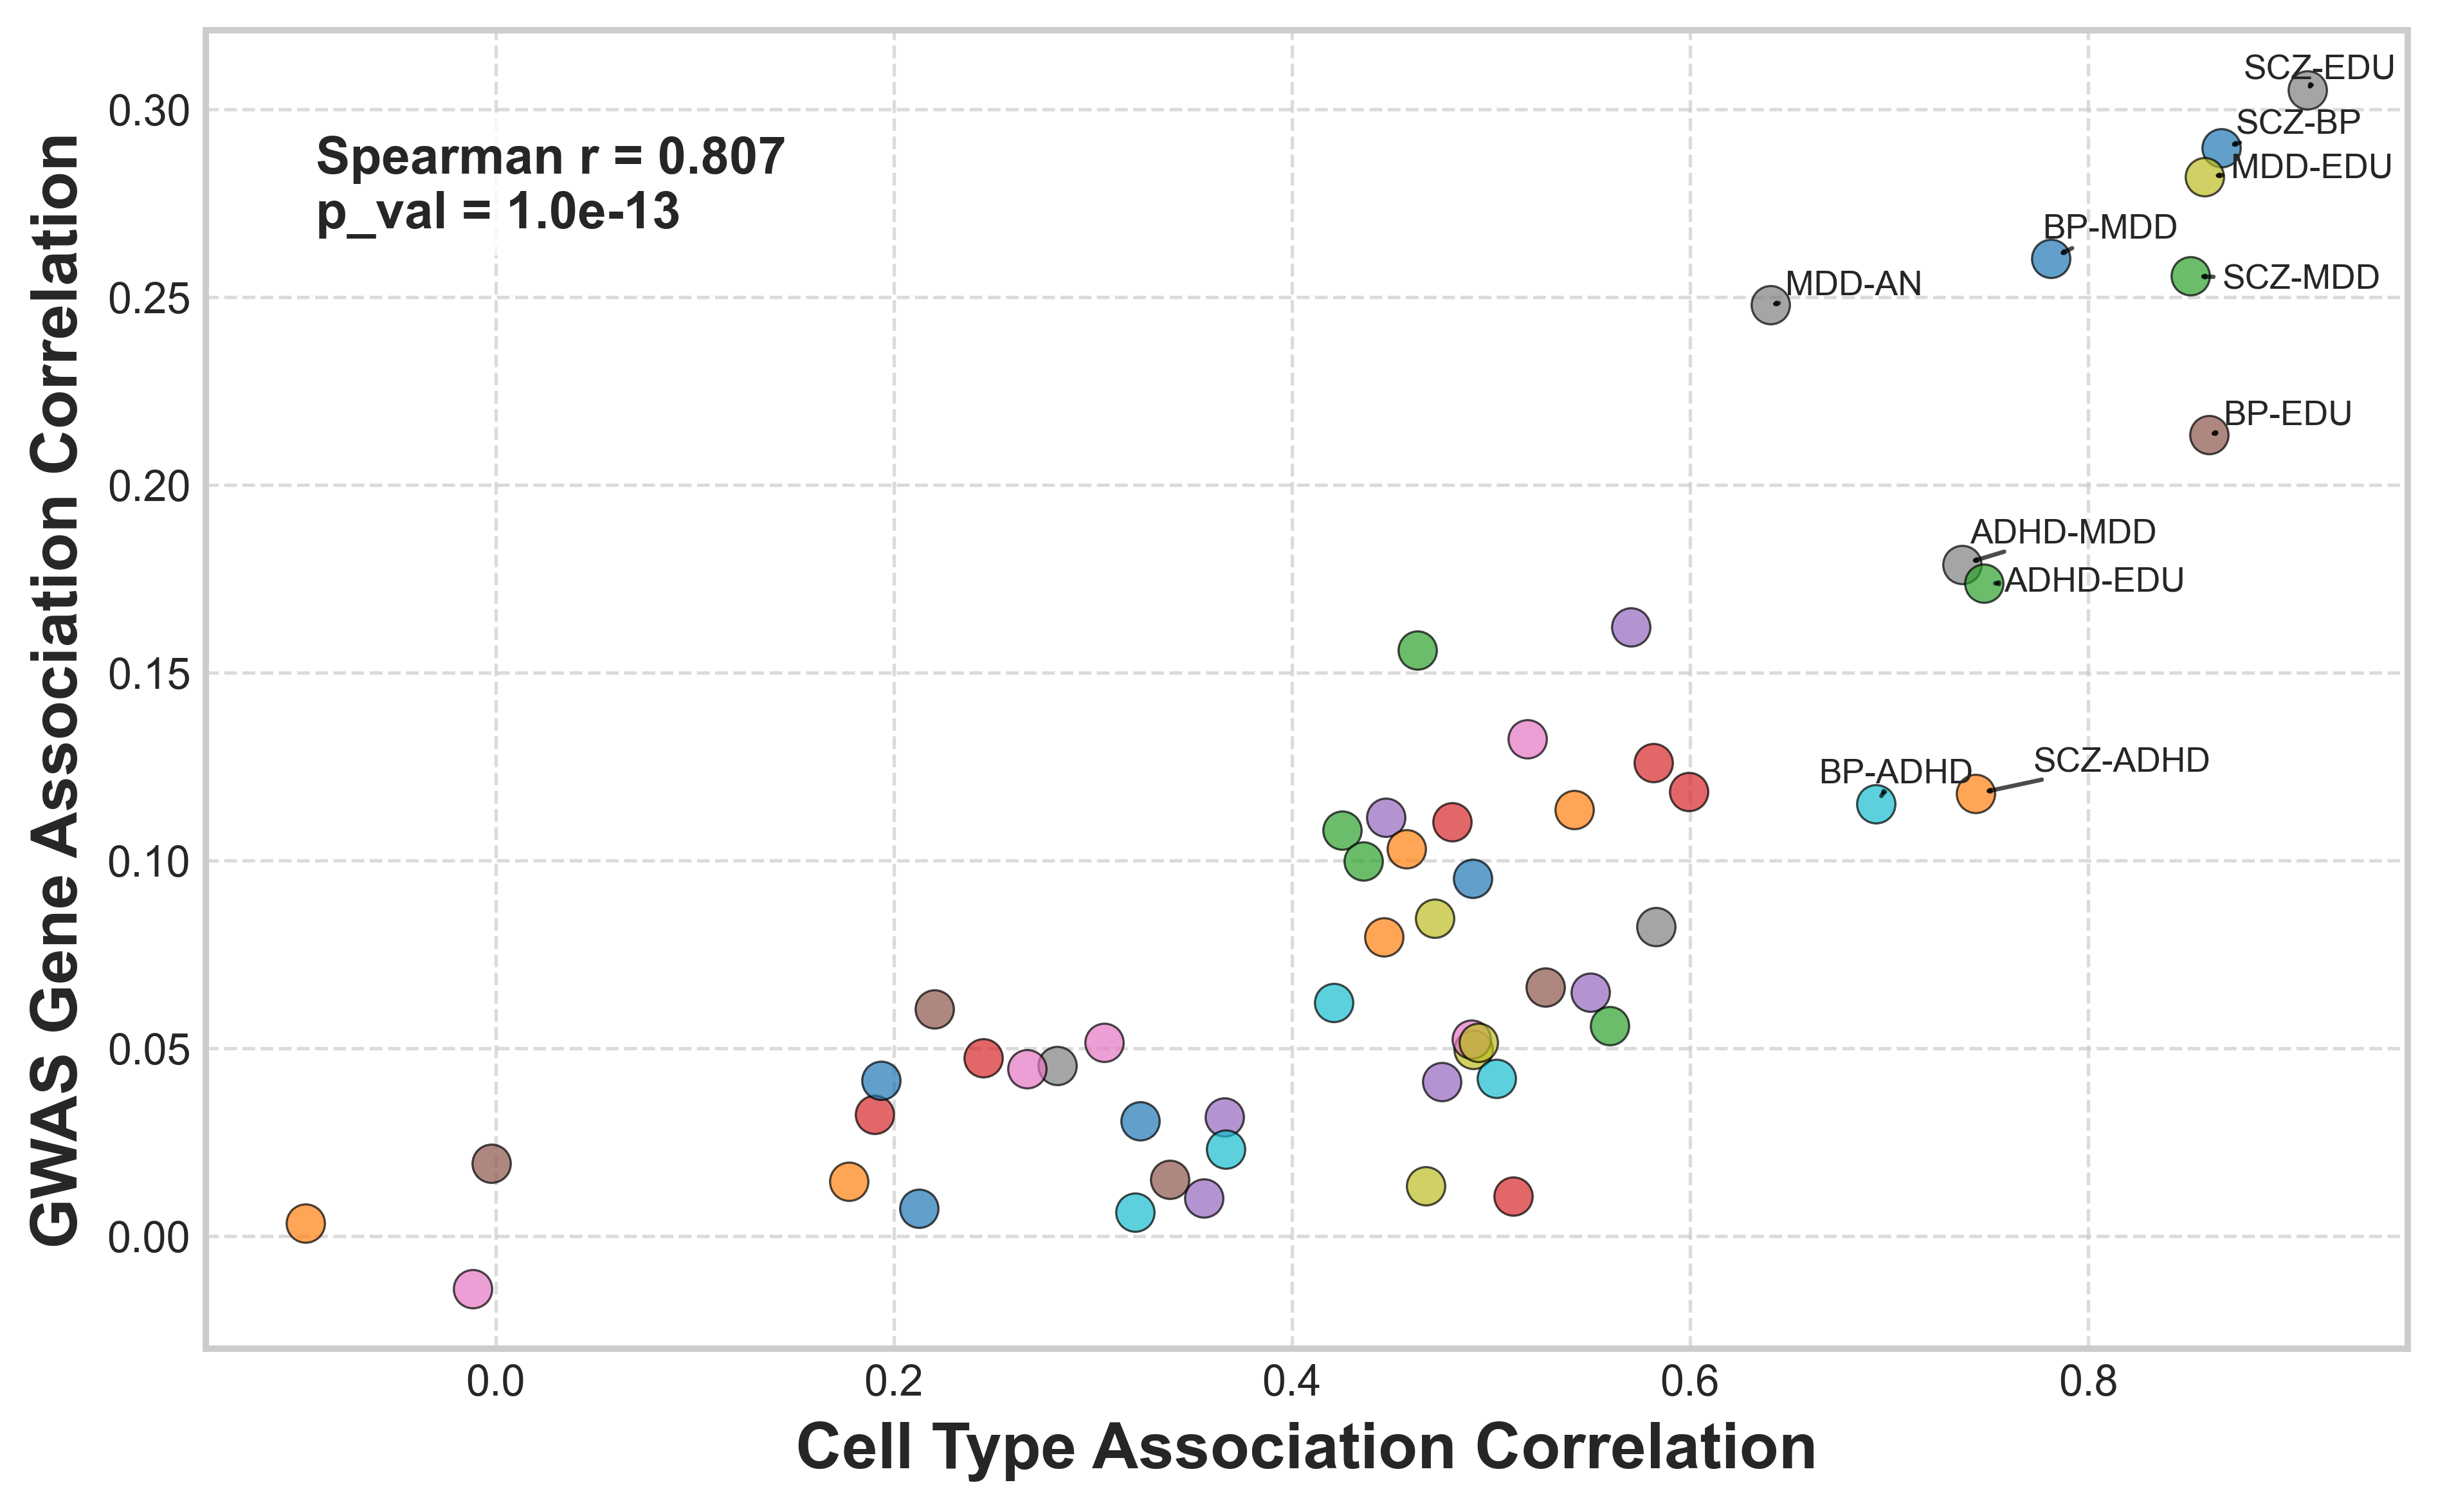

In [16]:
# Call the function with the data
plot_correlation_comparison_magmaGene_vs_Neural(PGC_Trait_Names, HumanCT_Bias_Correlation, PGC_Magma_Correlation)


#### PCA with Neural Bias Matrix

In [17]:
HumanCT_Bias_spec_scaled, humanCT_bias_spec_pca, humanCT_bias_spec_pca_result, humanCT_bias_spec_loadings = perform_pca_analysis(All_Bias_DF_Spec)
humanCT_bias_spec_pc_scores_df = pd.DataFrame(
    humanCT_bias_spec_pca_result,   
    index=All_Bias_DF_Spec.index,
    columns=[f'PC{i+1}' for i in range(humanCT_bias_spec_pca_result.shape[1])]
)

Explained variance ratios:
PC1: 0.556 (55.6%)
PC2: 0.120 (12.0%)
PC3: 0.064 (6.4%)
PC4: 0.055 (5.5%)
PC5: 0.054 (5.4%)
PC6: 0.047 (4.7%)
PC7: 0.041 (4.1%)
PC8: 0.031 (3.1%)
PC9: 0.015 (1.5%)
PC10: 0.010 (1.0%)
PC11: 0.007 (0.7%)

Cumulative variance explained: 100.0%

PC1 loadings:
SCZ     0.376565
EDU     0.374048
MDD     0.369926
BP      0.360393
ADHD    0.335339
OCD     0.275593
TS      0.261775
AN      0.250445
PTSD    0.247822
ASD     0.244665
PD      0.103097
Name: PC1, dtype: float64


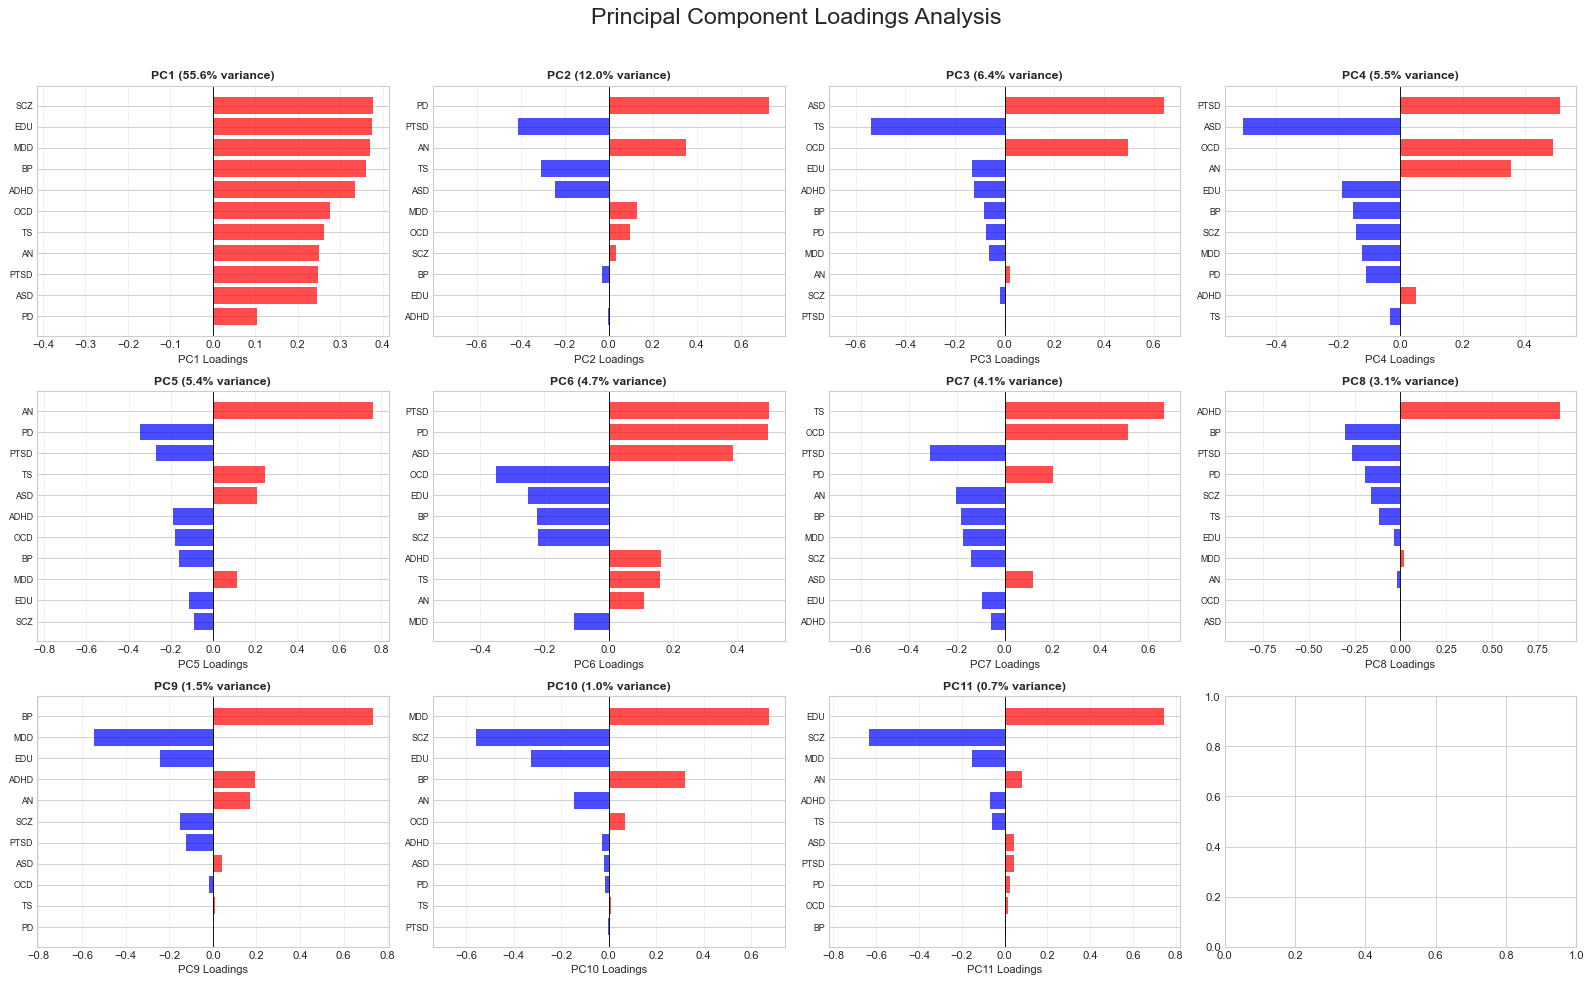

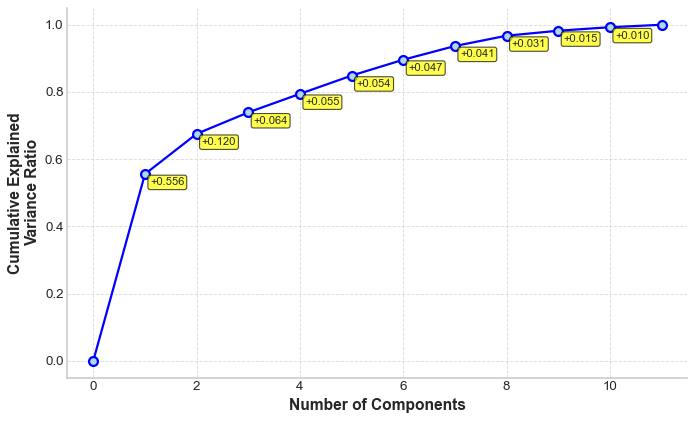

In [18]:
plot_pc_loadings(humanCT_bias_spec_pca, All_Bias_DF_Spec)
plot_scree_and_get_loadings(humanCT_bias_spec_pca)

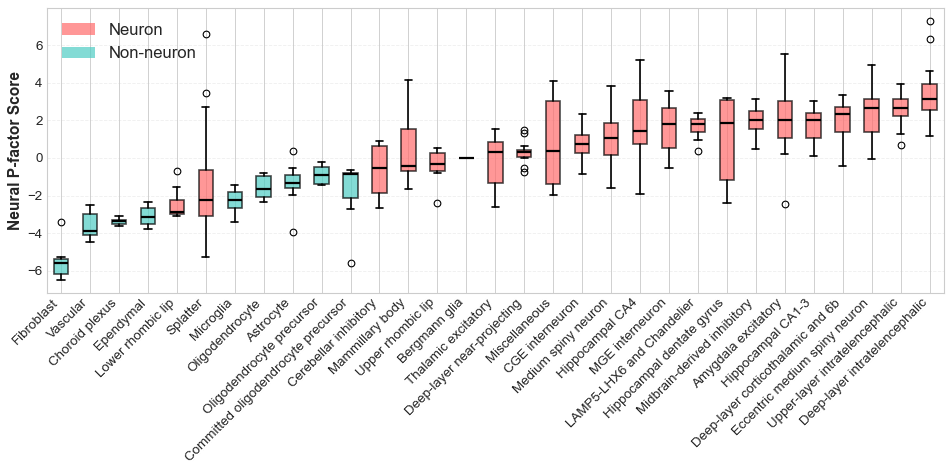

In [19]:
plot_Effect_boxplot_HumanCT(humanCT_bias_spec_pc_scores_df, Anno, ALL_CTs, "PC1", ylabel="Neural P-factor Score")

In [27]:
#### leave one out validation

In [45]:
# Leave-one-out PCA validation: for each disorder, leave it out, repeat PCA, and compare PC1 scores

# Prepare to collect leave-one-out PC1 scores for all disorders
# We'll build a DataFrame: rows = disorders, columns = ALL + each leave-one-out
loo_pc1_scores_df = pd.DataFrame(index=All_Bias_DF_Spec.index)

# "ALL" column: PC1 scores from PCA on all data
loo_pc1_scores_df["ALL"] = humanCT_bias_spec_pc_scores_df["PC1"]

# For each disorder, leave it out, fit PCA, and project all disorders into that PCA space
for disorder in All_Bias_DF_Spec.columns.values:
    # Leave out this disorder (drop as column, not index)
    df_loo = All_Bias_DF_Spec.drop(columns=disorder)
    # Fit PCA on the leave-one-out data
    _, pca_loo, pca_result_loo, _ = perform_pca_analysis(df_loo, verbose=False)
    pc1_scores_loo = pca_result_loo[:,0]
    # Store as a new column
    loo_pc1_scores_df[disorder] = pc1_scores_loo

# Now loo_pc1_scores_df has columns: "ALL" and one for each leave-one-out PCA


In [62]:
loo_pc1_scores_df.head(10)

,ALL,OCD,TS,PD,SCZ,ADHD,EDU,ASD,AN,BP,MDD,PTSD
ct_idx,,,,,,,,,,,,
0,0.083693,0.295106,0.223174,-0.063094,-0.142849,0.163753,0.069513,-0.165472,0.185621,-0.211846,0.228508,0.275093
1,-1.885666,-1.892095,-1.649175,-1.945765,-1.915843,-1.510783,-1.947143,-1.779956,-1.512499,-2.037354,-1.990370,-1.674023
2,-1.947888,-1.790501,-1.973449,-1.949095,-2.061100,-1.567746,-1.956131,-1.995287,-1.556000,-2.064031,-1.797582,-1.769517
3,-1.618900,-1.510829,-1.081110,-1.746267,-1.734328,-1.372800,-1.505439,-1.534066,-1.679379,-1.873221,-1.576054,-1.414210
4,-2.639089,-2.539209,-2.049145,-2.708717,-2.549176,-2.342001,-2.317526,-2.658009,-2.660862,-2.586148,-2.499756,-2.750679
5,-3.410197,-3.200998,-2.540676,-3.545885,-3.504944,-2.956474,-3.139934,-3.248546,-3.511900,-3.604660,-3.328354,-3.241612
6,-2.555034,-2.420826,-1.896615,-2.633048,-2.763540,-1.938566,-2.273160,-2.321946,-2.658978,-2.664993,-2.571584,-2.688775
7,-2.221698,-2.128596,-1.645621,-2.216787,-2.404789,-1.799897,-2.039653,-1.956927,-2.281792,-2.357600,-2.139450,-2.377891
8,-1.425525,-1.418048,-0.969645,-1.464265,-1.555682,-0.985649,-1.145516,-1.420805,-1.450115,-1.602108,-1.386530,-1.556892


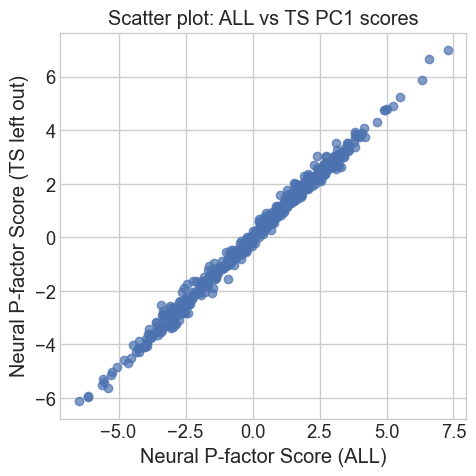

In [63]:
# Scatter plot between "ALL" and "TS" PC1 scores
plt.figure(figsize=(5,5), dpi=100)
plt.scatter(loo_pc1_scores_df["ALL"], loo_pc1_scores_df["TS"], alpha=0.7)
plt.xlabel("Neural P-factor Score (ALL)")
plt.ylabel("Neural P-factor Score (TS left out)")
plt.title("Scatter plot: ALL vs TS PC1 scores")
plt.grid(True)
plt.tight_layout()
plt.show()

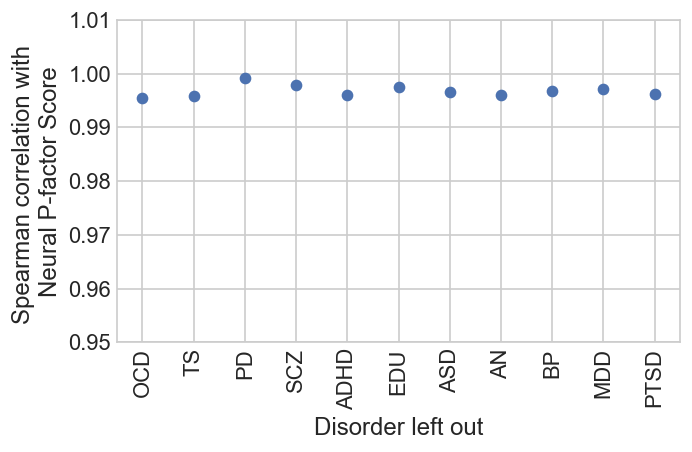

In [68]:
# Compute Spearman correlation between "ALL" and each leave-one-out PC1 score vector
from scipy.stats import spearmanr

correlations = []
disorders = []

for disorder in loo_pc1_scores_df.columns:
    if disorder == "ALL":
        continue
    corr, _ = spearmanr(loo_pc1_scores_df["ALL"], loo_pc1_scores_df[disorder])
    correlations.append(corr)
    disorders.append(disorder)

# Plot scatter: X = disorder left out, Y = correlation with ALL, Y range -1 to 1
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(6,4), dpi=120)
plt.scatter(disorders, correlations)
plt.ylim(0.95, 1.01)
plt.xticks(rotation=90)
plt.xlabel("Disorder left out")
plt.ylabel("Spearman correlation with \nNeural P-factor Score")
#plt.title("Spearman correlation of leave-one-out PC1 with ALL")
plt.tight_layout()
plt.show()

#### Correlation with PSD

In [20]:
Jon_PSD_list = "88 102 107 114 118 119 120 150 375 476 491 538 575 577 613 659 664 747 775 815 832 1000 1020 1128 1136 1499 1500 1501 1612 1627 1630 1739 1740 1741 1742 1785 1821 1838 1855 1948 1949 2039 2043 2059 2066 2171 2185 2332 2534 2596 2785 2852 2890 2891 2892 2893 2894 2895 2897 2898 2899 2900 2901 2902 2903 2904 2905 2906 2911 2913 2915 3184 3188 3337 3631 3646 3708 3756 3836 4038 4131 4218 4355 4744 4804 4842 4897 4905 4915 4985 5028 5062 5063 5064 5071 5093 5094 5142 5170 5582 5590 5621 5662 5728 5800 5802 6009 6128 6129 6132 6136 6156 6169 6175 6188 6207 6208 6222 6223 6230 6232 6252 6334 6457 6536 6543 6546 6547 6695 6711 6790 6792 6801 6853 6854 7074 7248 7249 7428 7732 7779 8087 8224 8440 8502 8516 8661 8777 8787 8825 8831 8851 8898 8927 8997 9026 9045 9101 9148 9162 9194 9201 9228 9229 9231 9419 9454 9455 9456 9463 9478 9495 9513 9743 9746 9762 9829 9863 9867 9890 9912 9921 9922 10006 10142 10243 10280 10313 10368 10369 10458 10486 10505 10509 10611 10636 11122 11178 11331 11346 22829 22849 22865 22866 22871 22883 22941 22986 22997 23043 23208 23229 23237 23362 23380 23413 23426 23513 23542 23623 23705 23767 25945 25978 26012 26037 26045 26052 27020 27091 27092 27185 27445 28964 28988 29102 29904 50488 50944 51104 51201 51225 54477 54487 54583 54910 55327 55450 55607 55737 56899 56924 57120 57142 57479 57502 57537 57554 57622 57679 57689 58489 58512 59283 59284 64084 64101 64130 64506 66000 78999 79414 79870 79953 80315 80725 80758 80852 80863 81831 81832 81926 84062 84435 84687 85358 85461 94030 112476 114798 116443 116444 145581 145773 146395 152404 158866 160622 200933 201191 254263 339451 347731 373509 388135 388336 392862 400745 401190 440073 440829 642938 729956 729993 100131897"
Jon_PSD_list = [int(x) for x in Jon_PSD_list.split(" ")]
Jon_PSD_GW = dict(zip(Jon_PSD_list, np.ones(len(Jon_PSD_list))))
HumanCT_PSD_Spec = HumanCT_AvgZ_Weighted(BiasMat, Jon_PSD_GW)
HumanCT_PSD_Spec = AnnotateCTDat(HumanCT_PSD_Spec, Anno)
HumanCT_PSD_Spec.to_csv("/home/jw3514/Work/UNIMED/results/goterms/HumanCT_PSD_Spec.csv")

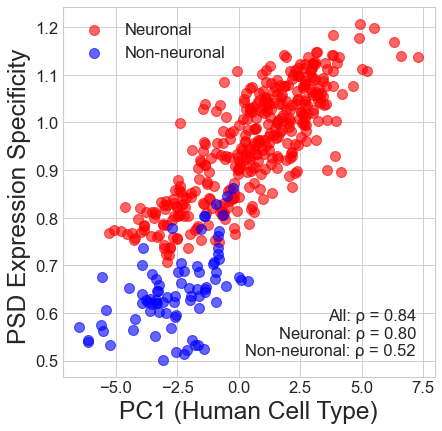

In [21]:
values1 = humanCT_bias_spec_pc_scores_df.sort_index()["PC1"].values
values2 = HumanCT_PSD_Spec.sort_index()["EFFECT"].values
plot_correlation_humanCT(values1, values2, "PC1 (Human Cell Type)", "PSD Expression Specificity ", "", Neur_idx=Neur_idx, NonNeur_idx=NonNeur_idx)

#### Remove PC1 

In [22]:
pc1_effect = humanCT_bias_spec_pca_result[:, 0].reshape(-1, 1) @ humanCT_bias_spec_pca.components_[0].reshape(1, -1)
residuals = HumanCT_Bias_spec_scaled - pc1_effect
residueDF = pd.DataFrame(residuals, 
             columns=All_Bias_DF_Spec.columns,
             index=All_Bias_DF_Spec.index)

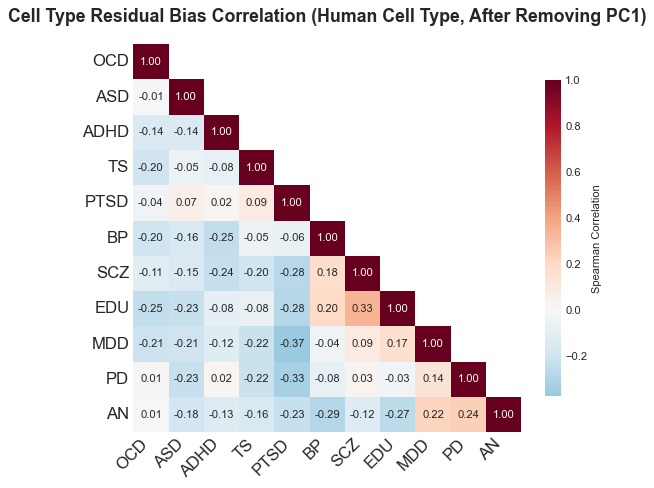

In [23]:
HumanCT_ResidueBias_Correlation = plot_disorder_correlation_heatmap(residueDF, "Cell Type Residual Bias Correlation (Human Cell Type, After Removing PC1)")

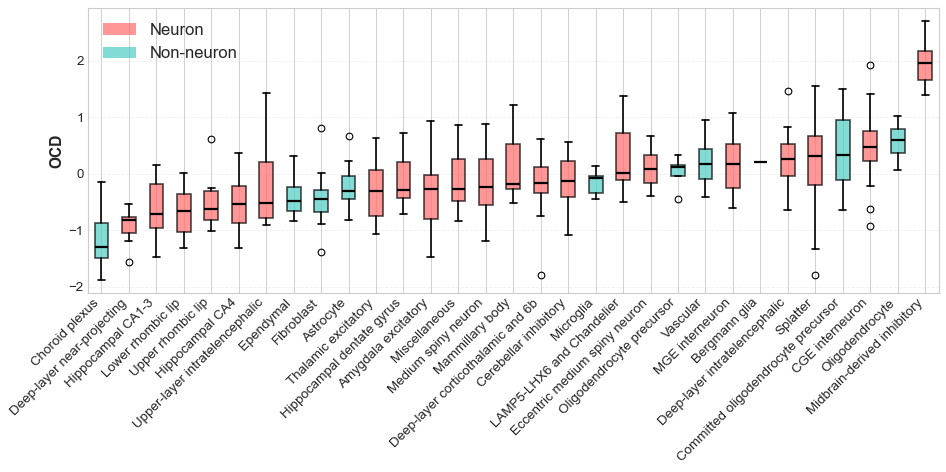

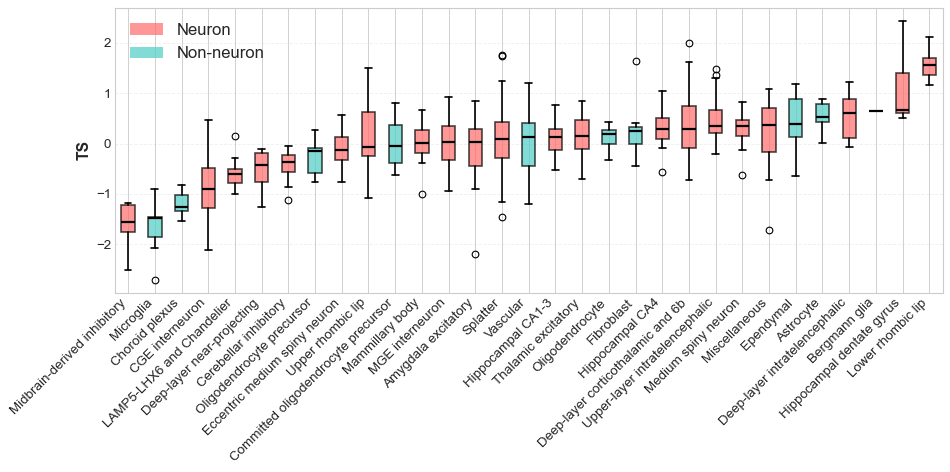

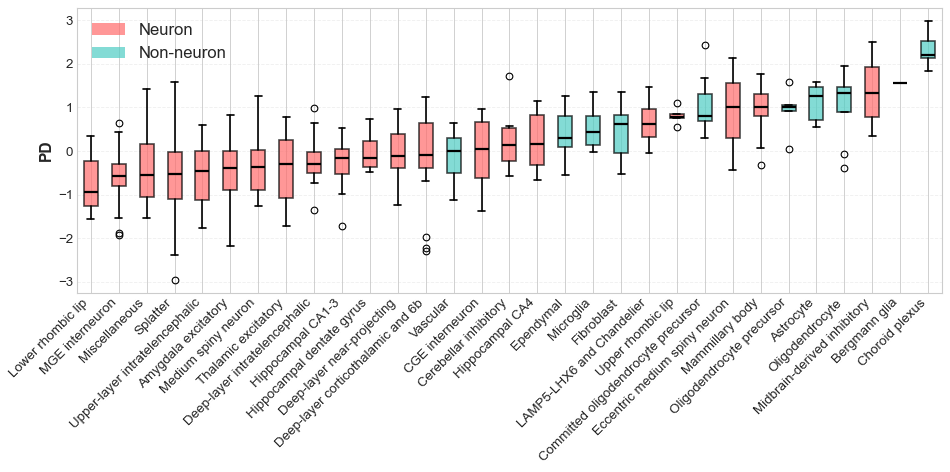

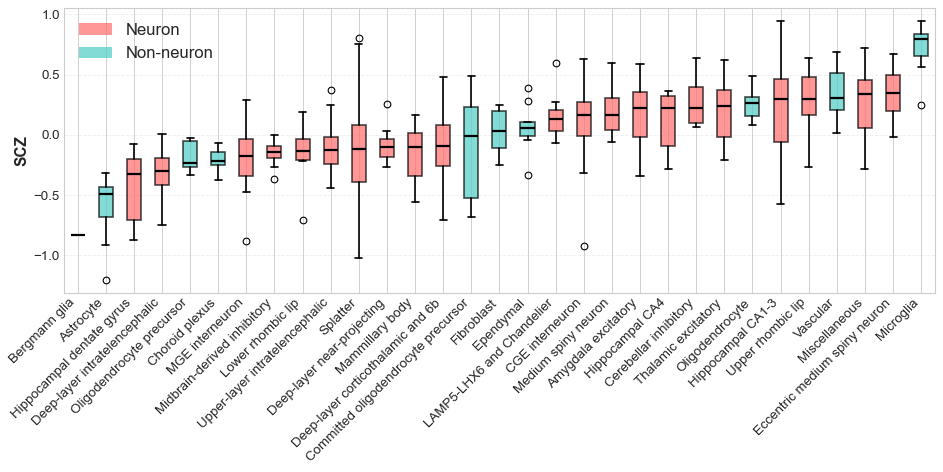

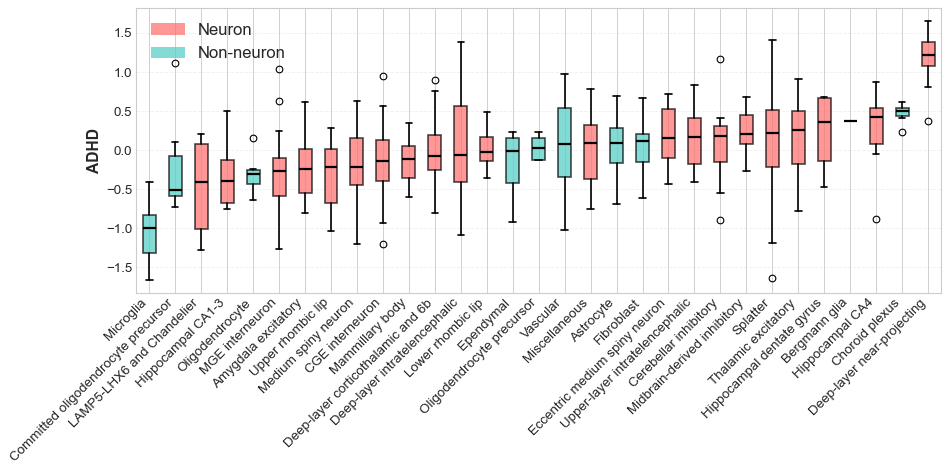

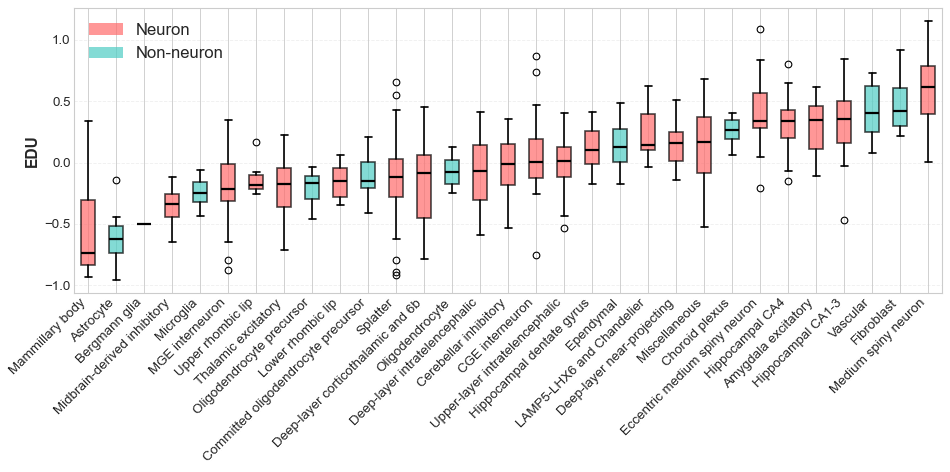

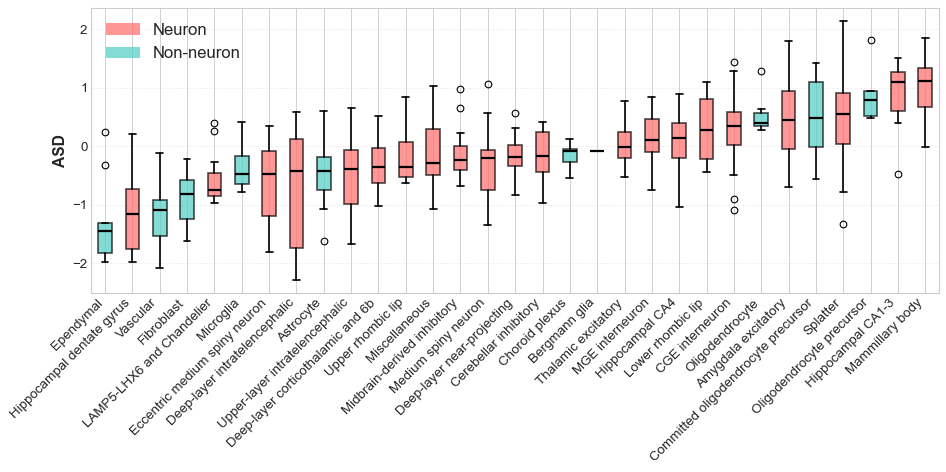

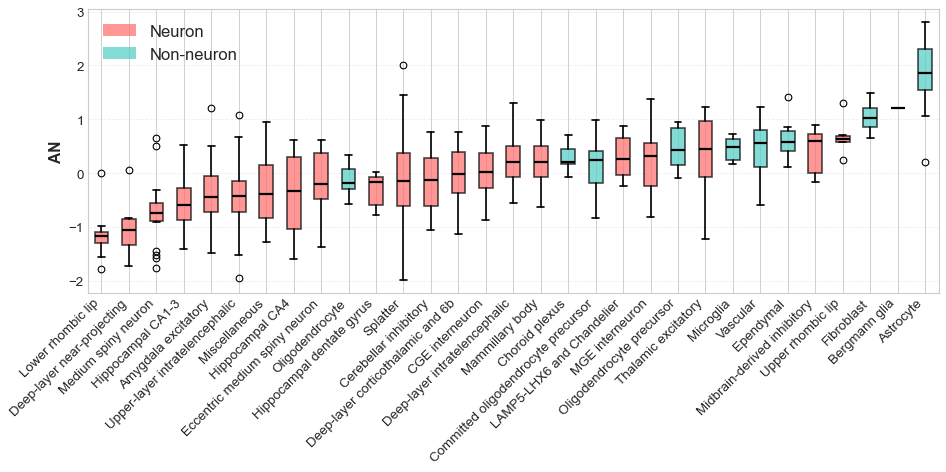

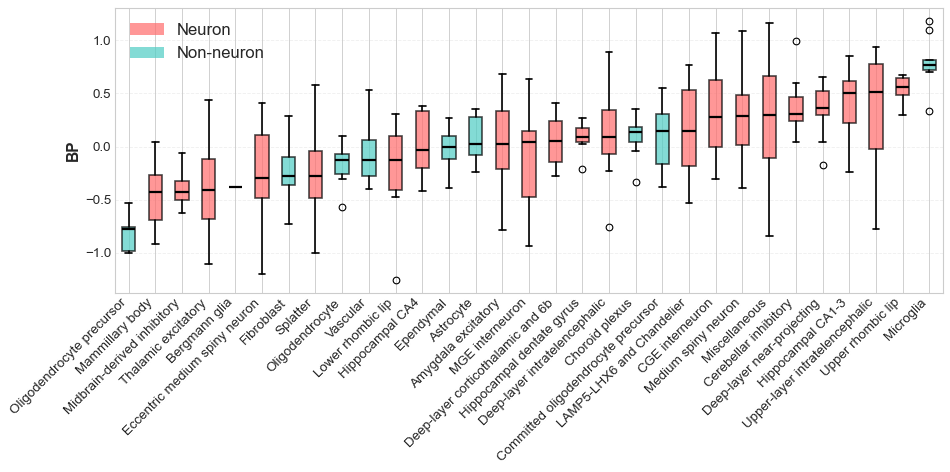

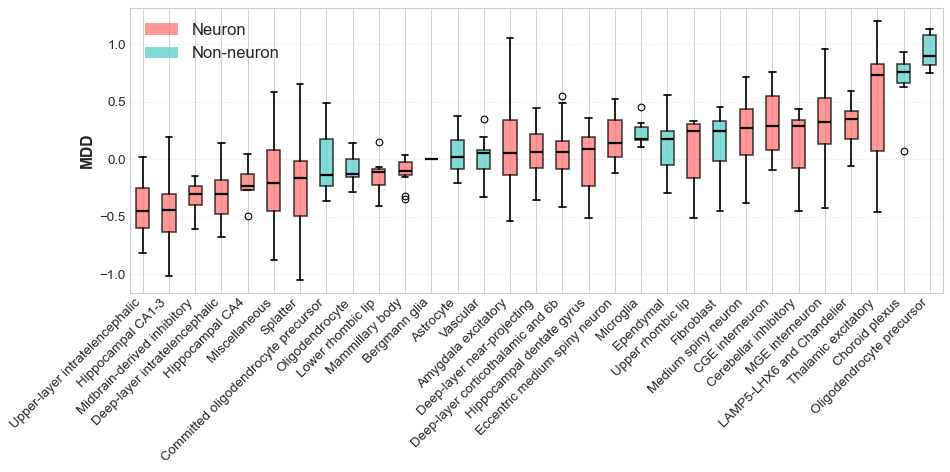

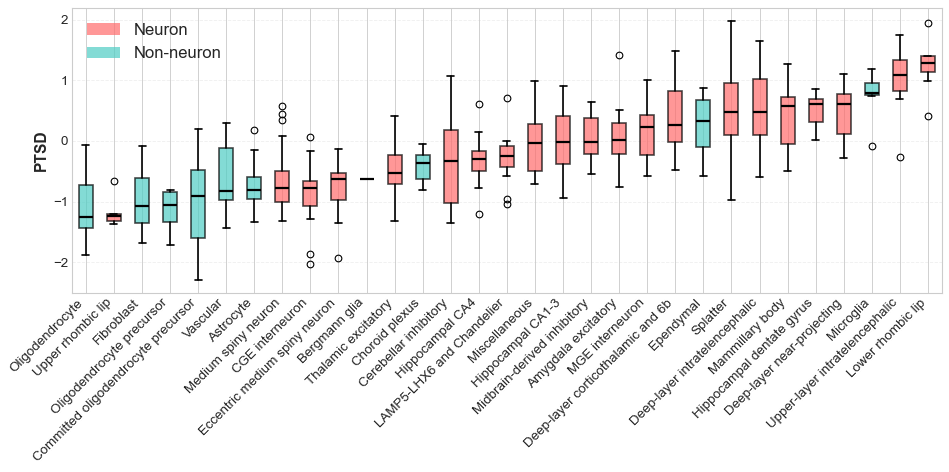

In [24]:
for Disorder in residueDF.columns.values:
    plot_Effect_boxplot_HumanCT(residueDF, Anno, ALL_CTs, Disorder, Disorder, )

# Other biases with human CT 

In [25]:
LOEUF = pd.read_csv("/home/jw3514/Work/UNIMED/dat/LOEUF_Rankings.csv", index_col="EntrezID")
# take top 10 decile 
topN = LOEUF.shape[0]//10
LOEUF_top10 = LOEUF.sort_values("LOEUF", ascending=True).head(topN)
print(LOEUF_top10.shape)
LOEUF_top10_GW = dict(zip(LOEUF_top10.index, np.ones(len(LOEUF_top10))))
HumanCT_LOEUF_Spec = HumanCT_AvgZ_Weighted(BiasMat, LOEUF_top10_GW)
HumanCT_LOEUF_Spec = AnnotateCTDat(HumanCT_LOEUF_Spec, Anno)
HumanCT_LOEUF_Spec.to_csv("/home/jw3514/Work/UNIMED/results/goterms/HumanCT_LOEUF_Spec.csv")

(1800, 4)


In [26]:
LOEUF_top10

,GeneSymbol,LOEUF,ExACpLI,sHet
EntrezID,,,,
9969,MED13,0.030,1.00000,0.608889
25836,NIPBL,0.032,1.00000,0.573090
9126,SMC3,0.037,1.00000,0.586268
23019,CNOT1,0.038,1.00000,0.330130
6018,RLF,0.040,1.00000,0.547053
...,...,...,...,...
53615,MBD3,0.260,0.91932,0.273802
1832,DSP,0.260,0.99990,0.049954
6543,SLC8A2,0.260,NaN,NaN
